# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database. The goals of this analysis include:

1. Evaluating the Sepsis-3 guidelines in MIMIC using the same methodology as in the research paper
2. Evaluating the Sepsis-3 guidelines against ANGUS criteria
3. Assessing if there are interesting subgroup(s) which are missed by the criteria

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sys
import statsmodels.api as sm

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

from sklearn.pipeline import Pipeline

# used for train/test splits
from sklearn.cross_validation import train_test_split

# used to impute mean for data
from sklearn.preprocessing import Imputer

# normalize the data
from sklearn import preprocessing

# logistic regression is our model of choice
from sklearn.linear_model import LogisticRegression

# used to create confusion matrix
from sklearn.metrics import confusion_matrix

from sklearn.cross_validation import cross_val_score

# used to calculate AUROC/accuracy
from sklearn import metrics

# for calibration curve of severity scores
from sklearn.calibration import calibration_curve


# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

In [2]:
# create a database connection

# below config used on pc70
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [3]:
# call functions to extract the severity scores
qsofa = su.get_qsofa(con)
sofa = su.get_sofa(con)
oasis = su.get_oasis(con)
lods = su.get_lods(con)
sirs = su.get_sirs(con)
angus = su.get_angus(con)

# Time of suspected infection

Suspected infection is defined as:

* Antibiotics within 72 hours of a culture
* A culture within 24 hours of antibiotics

We can extract antibiotic usage from the, PRESCRIPTIONS, INPUTEVENTS_MV and INPUTEVENTS_CV tables. We can extract time of blood cultures from the MICROBIOLOGYEVENTS table. Detail is given in defining-suspected-infection.ipynb.

In [4]:
ab = su.get_suspected_infection_time(con)

# Other data

This query extracts other data of interest:

* Age
* Gender
* Immunosuppression
* BMI
* Metastatic cancer (Elixhauser comorbidity)
* Diabetes (Elixhauser comorbidity)


In [5]:
misc = su.get_other_data(con)

In [6]:
print('{} ICU stays.').format(misc.shape[0])
idx = misc.age > 1
print('{} adult ICU stays.').format(np.sum(idx))
demog_col = ['height','weight','bmi']
for c in demog_col:
    print('\t{:2.2f}% have {}.').format( (np.sum(idx) - misc[c][idx].isnull().sum())*100.0 / np.sum(idx), c )

61532 ICU stays.
53432 adult ICU stays.
	75.45% have height.
	88.74% have weight.
	69.44% have bmi.


# Clinical covariates

We are interesting in studying the relationship between "true" Sepsis cases (as defined by Angus criteria) and true/false positives according to qSOFA/SOFA. To accomplish this we extract a host of data from these patients.

In [7]:
dd = su.get_physiologic_data(con)
dd.head(n=5)

,icustay_id,heartrate_min,heartrate_max,sysbp_min,sysbp_max,diasbp_min,diasbp_max,meanbp_min,meanbp_max,resprate_min,...,rrt,urineoutput,mechvent,vasopressor,aado2_min,pao2fio2_min,arterialph_min,arterialph_max,paco2_min,paco2_max
0,200024,101,123,75,125,59,81,66.000000,100,18,...,0,NaN,1,1,NaN,397.500000,7.20,7.20,29,29
1,200030,84,115,94,145,45,72,63.666698,89,11,...,0,3970,0,1,NaN,NaN,7.36,7.41,28,32
2,200099,68,93,95,177,32,65,50.000000,102,9,...,0,955,0,0,NaN,111.428571,7.33,7.45,27,51
3,200116,46,73,91,179,49,144,59.000000,153,9,...,0,3050,0,1,NaN,NaN,7.40,7.40,45,45
4,200118,134,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,135,1,0,NaN,184.000000,7.41,7.41,44,44


# Cohort

The below code creates our cohort of interest. This cohort is used to apply inclusion criteria by means of an inner join. Inclusion criteria are:

* Adult patient, i.e. age >= 16
* First ICU stay for the patient

In [8]:
cohort = su.get_cohort(con)

In [9]:
# close the database connection as we are finished extracting data
con.close()

# Create dataframe with all covariates extracted

In [10]:
# initialize our dataframe to the cohort
df_all_pt = cohort

# merge in the various severity scores
df_all_pt = df_all_pt.merge(qsofa, how='left', on='icustay_id',
                suffixes=('','_qsofa'))
df_all_pt = df_all_pt.merge(sofa, how='left', on='icustay_id',
                suffixes=('','_sofa'))
df_all_pt = df_all_pt.merge(sirs, how='left', on='icustay_id',
                suffixes=('','_sirs'))
df_all_pt = df_all_pt.merge(ab, how='left', on='icustay_id',
                suffixes=('','_ab'))
df_all_pt = df_all_pt.merge(misc, how='left', on='icustay_id',
                suffixes=('','_misc'))
df_all_pt = df_all_pt.merge(oasis, how='left', on='icustay_id',
                suffixes=('','_oasis'))
df_all_pt = df_all_pt.merge(lods, how='left', on='icustay_id',
                suffixes=('','_lods'))

df_all_pt = df_all_pt.merge(angus, how='left', on='hadm_id',
                suffixes=('','_angus'))

# define sepsis-3 as: qSOFA >= 2 and SOFA >= 2
df_all_pt['sepsis3'] = (df_all_pt.qsofa >= 2) & (df_all_pt.sofa >=2)

df_all_pt.head()

,icustay_id,hadm_id,intime,outtime,year,qsofa,sysbp_score_qsofa,resprate_score_qsofa,gcs_score_qsofa,subject_id,...,pulmonary_lods,hematologic_lods,hepatic_lods,subject_id_angus,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus,sepsis3
0,211552,145834,2101-10-20 19:10:11,2101-10-26 20:43:09,2002,2,1,1,0,3,...,1,0,1,3,1,0,1,1,1,True
1,294638,185777,2191-03-16 00:29:31,2191-03-17 16:46:31,2004,2,1,1,0,4,...,0,0,0,4,1,0,0,0,0,True
2,228232,107064,2175-05-30 21:30:54,2175-06-03 13:39:54,2005,0,0,0,0,6,...,0,0,1,6,0,0,0,0,0,False
3,220597,150750,2149-11-09 13:07:02,2149-11-14 20:52:14,2003,0,0,0,0,9,...,3,0,0,9,0,0,1,1,0,False
4,229441,194540,2178-04-16 06:19:32,2178-04-17 20:21:05,2007,3,1,1,1,11,...,0,0,NaN,11,0,0,0,0,0,True


In [11]:
df_all_pt.describe()

,icustay_id,hadm_id,year,qsofa,sysbp_score_qsofa,resprate_score_qsofa,gcs_score_qsofa,subject_id,hadm_id_sofa,sofa,...,pulmonary_lods,hematologic_lods,hepatic_lods,subject_id_angus,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus,sepsis3
count,38597.000000,38597.000000,38597.000000,38597.000000,37895.000000,37871.000000,37792.000000,38597.000000,38597.000000,38597.000000,...,38597.000000,37832.000000,34997.000000,38597.000000,38597.000000,38597.000000,38597.000000,38597.000000,38597.000000,38597
mean,250214.529471,150056.982822,2006.992279,1.692567,0.705344,0.832352,0.187262,38268.563438,150056.982822,3.957121,...,0.574552,0.036900,0.557333,38268.563438,0.393968,0.070472,0.378423,0.270125,0.273985,0.561313
std,28919.986152,28944.439346,3.209268,0.747677,0.455894,0.373558,0.390127,29378.091364,28944.439346,3.049349,...,0.883966,0.268065,0.496709,29378.091364,0.488634,0.255944,0.485000,0.444030,0.446007,0.496233
min,200003.000000,100001.000000,2001.000000,0.000000,0.000000,0.000000,0.000000,3.000000,100001.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
25%,225209.000000,124931.000000,2004.000000,1.000000,0.000000,1.000000,0.000000,13980.000000,124931.000000,2.000000,...,0.000000,0.000000,0.000000,13980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
50%,250261.000000,150134.000000,2007.000000,2.000000,1.000000,1.000000,0.000000,27912.000000,150134.000000,3.000000,...,0.000000,0.000000,1.000000,27912.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
75%,275290.000000,175258.000000,2010.000000,2.000000,1.000000,1.000000,0.000000,62975.000000,175258.000000,5.000000,...,1.000000,0.000000,1.000000,62975.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1
max,299999.000000,199999.000000,2012.000000,3.000000,1.000000,1.000000,1.000000,99999.000000,199999.000000,22.000000,...,3.000000,3.000000,1.000000,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True


We can ask some pretty sensible questions of this data.

* What percentage of patients had antibiotics with a culture?
* What percentage of these cultures were positive?

In [12]:
print('{:5g} adult ICU stays (excluding subsequent ICU stays for the same patient).').format(
    df_all_pt.shape[0])

print('{:2.2f}% of patients with antibiotics/culture').format(
    df_all_pt['suspected_infection_time'].count().astype(float) / df_all_pt.shape[0] * 100)

print('{:2.2f}% of patients with positive cultures').format(
    df_all_pt['positiveculture'].sum().astype(float) / df_all_pt.shape[0] * 100)

print('{:2.2f}% of patients with antibiotics/culture had a positive culture').format(
    df_all_pt['positiveculture'].sum().astype(float) / df_all_pt['suspected_infection_time'].count().astype(float) * 100)

38597 adult ICU stays (excluding subsequent ICU stays for the same patient).
20.17% of patients with antibiotics/culture
2.41% of patients with positive cultures
11.93% of patients with antibiotics/culture had a positive culture


The Sepsis-3 guidelines exclusively evaluated patients with suspected infection, so we subselect to this population.

In [13]:
df = df_all_pt.loc[(~df_all_pt['suspected_infection_time'].isnull().values)]

# Study population

Demographics, etc.

In [14]:
su.print_demographics(df)

age                 	73.72 +- 51.15
gender              	58.11%
bmi                 	28.96 +- 8.67
hospital_expire_flag	11.23%
thirtyday_expire_flag	13.32%
icu_los             	4.24 +- 5.77
hosp_los            
mech_vent           	29.58%


In [15]:
print('{:5g} have qSOFA >= 2 ({:2.2f}%).').format(
    (df.qsofa.values >= 2).sum(),100.0*(df.qsofa.values >= 2).mean())

print('{:5g} have SOFA >= 2 ({:2.2f}%).').format(
    (df.sofa.values >= 2).sum(),100.0*(df.sofa.values >= 2).mean())

print('{:5g} have Sepsis-3 ({:2.2f}%).').format(
    (df.sepsis3).sum(),100.0*(df.sepsis3).mean())

print('{:5g} have SIRS >= 2 ({:2.2f}%).').format(
    (df.sirs.values >= 2).sum(),100.0*(df.sirs.values >= 2).mean())

print('{:5g} have LODS >= 2 ({:2.2f}%).').format(
    (df.lods.values >= 2).sum(),100.0*(df.lods.values >= 2).mean())

 5864 have qSOFA >= 2 (75.32%).
 6788 have SOFA >= 2 (87.19%).
 5360 have Sepsis-3 (68.85%).
 7294 have SIRS >= 2 (93.69%).
 7101 have LODS >= 2 (91.21%).


# Study questions

1. How well do the guidelines detect sepsis (Angus criteria) in the antibiotics/culture subset?
2. How well do the guidelines predict mortality (in-hospital) in the antibiotics/culture subset?
3. What factors would improve the sensitivity of the guidelines?
4. What factors would improve the specificity of the guidelines?

## Angus criteria evaluation

In [16]:
# define targets, angus critera
y = df.angus.values == 1

# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat = (df.qsofa.values >= 2) & (df.sofa.values>=2)

print('\n SEPSIS-3 guidelines for Angus criteria sepsis \n')
# generate evaluation metrics
print 'Accuracy = {}'.format(metrics.accuracy_score(y, yhat))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for Angus criteria sepsis 

Accuracy = 0.519075144509

Confusion matrix
   	yhat=0	yhat=1
y=0	  1670	  2989	NPV=68.87
y=1	   755	  2371	PPV=44.24
   	35.84	75.85	Acc=51.91
   	Spec	Sens


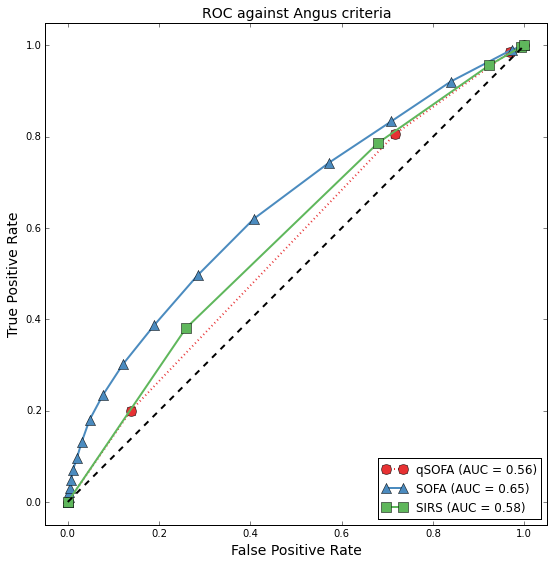

In [17]:
y = df.angus.values == 1

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.figure(figsize=[9,9])
plt.plot(fpr_qsofa, tpr_qsofa, 'o:',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = %0.2f)' % auc_qsofa)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = %0.2f)' % auc_sofa)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = %0.2f)' % auc_sirs)

# add in the combination of SIRS/SOFA
#plt.plot(fpr_s3, tpr_s3, 'd--',
#         color=col[3], linewidth=2, markersize=10,
#         label='SEPSIS-3 (AUC = %0.2f)' % auc_s3)

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC against Angus criteria',fontsize=14)
plt.show()

In [18]:
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [df.qsofa.values >= 2,
            df.sofa.values >= 2,
            df.sepsis3.values,
            df.sirs.values >= 2]
yhat_names = ['qsofa','sofa','seps3','SIRS']

# define "targets", angus critera
y_all = [df.angus.values == 1,
         df.angus.values == 1,
         df.angus.values == 1,
         df.angus.values == 1]


stats_all = su.print_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=['angus criteria sepsis'])

Metric
	angus criteria sepsis 

	qsofa 	sofa  	seps3 	SIRS  
TN    	 1316 	  750 	 1670 	  356 
FP    	 3343 	 3909 	 2989 	 4303 
FN    	  605 	  247 	  755 	  135 
TP    	 2521 	 2879 	 2371 	 2991 
Sens  	80.65 	92.10 	75.85 	95.68 
Spec  	28.25 	16.10 	35.84 	 7.64 
PPV   	42.99 	42.41 	44.24 	41.01 
NPV   	68.51 	75.23 	68.87 	72.51 
F1    	56.08 	58.08 	55.88 	57.41 
DOR   	 1.64 	 2.24 	 1.75 	 1.83 


# Hospital mortality evaluation

In [19]:
# define targets, angus critera
y = df.hospital_expire_flag.values == 1

# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat = (df.qsofa.values >= 2) & (df.sofa.values>=2)

print('\n SEPSIS-3 guidelines for hospital mortality \n')
# generate evaluation metrics
print 'Accuracy = {}'.format(metrics.accuracy_score(y, yhat))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for hospital mortality 

Accuracy = 0.387283236994

Confusion matrix
   	yhat=0	yhat=1
y=0	  2283	  4628	NPV=94.14
y=1	   142	   732	PPV=13.66
   	33.03	83.75	Acc=38.73
   	Spec	Sens


In [ ]:
y = df.hospital_expire_flag.values == 1

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.figure(figsize=[9,9])
plt.plot(fpr_qsofa, tpr_qsofa, 'o:',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = %0.2f)' % auc_qsofa)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = %0.2f)' % auc_sofa)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = %0.2f)' % auc_sirs)

# add in the combination of SIRS/SOFA
#plt.plot(fpr_s3, tpr_s3, 'd--',
#         color=col[3], linewidth=2, markersize=10,
#         label='SEPSIS-3 (AUC = %0.2f)' % auc_s3)

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC against hospital mortality',fontsize=14)
plt.show()

In [ ]:
# histogram of the qSOFA values in septic/non-septic population

y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

# plot the data
plt.figure(figsize=[9,9])
plt.hist(qsofa_alive, bins=xi, normed=True, color=col[0], alpha=0.5,
         label='qSOFA - survived')
plt.hist(qsofa_dead, bins=xi, normed=True, color=col[1], alpha=0.5,
         label='qSOFA - died')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Count',fontsize=14)
#plt.title('ROC against hospital mortality',fontsize=14)
plt.show()


In [ ]:
y = df.hospital_expire_flag.values == 1
plt.figure(figsize=[9,9])

# === NORMAL EMPIRICALLY DERIVED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, 'o-',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = %0.2f)' % auc_qsofa)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = %0.2f)' % auc_sofa)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = %0.2f)' % auc_sirs)


# === BINORMAL ESTIMATED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = su.binormal_roc(df.qsofa.values[~y], df.qsofa.values[y])
auc_qsofa = su.binormal_auroc(df.qsofa.values[~y], df.qsofa.values[y])

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = su.binormal_roc(df.sofa.values[~y], df.sofa.values[y])
auc_sofa = su.binormal_auroc(df.sofa.values[~y], df.sofa.values[y])

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = su.binormal_roc(df.sirs.values[~y], df.sirs.values[y])
auc_sirs = su.binormal_auroc(df.sirs.values[~y], df.sirs.values[y])

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, '--',
         color=col[0], linewidth=2, markersize=10)
plt.plot(fpr_sofa, tpr_sofa, '--',
         color=col[1], linewidth=2, markersize=10)
plt.plot(fpr_sirs, tpr_sirs, '--',
         color=col[2], linewidth=2, markersize=10)

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Binormal ROC against hospital mortality',fontsize=14)
plt.show()

In [ ]:
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [df.qsofa.values >= 2,
            df.sofa.values >= 2,
            df.sepsis3.values,
            df.sirs.values >= 2]
yhat_names = ['qsofa','sofa','seps3','SIRS']

# define "targets", angus critera
y_all = [df.hospital_expire_flag.values == 1,
         df.hospital_expire_flag.values == 1,
         df.hospital_expire_flag.values == 1,
         df.hospital_expire_flag.values == 1]


stats_all = su.print_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=['in-hospital mortality'])

## What factors would improve Sepsis-3 guidelines?

In [ ]:
# initialize our dataframe to the cohort
dm = cohort
dm = dm.merge(dd, how='inner', on='icustay_id',suffixes=('','_dd'))
dm = dm.merge(ab, how='inner', on='icustay_id',suffixes=('','_ab'))
dm = dm.merge(angus, how='inner', on='hadm_id',suffixes=('','_angus'))
dm = dm.merge(qsofa, how='inner', on='icustay_id',suffixes=('','_qsofa'))
dm = dm.merge(sofa, how='inner', on='icustay_id',suffixes=('','_sofa'))
dm = dm.merge(sirs, how='inner', on='icustay_id',suffixes=('','_sirs'))

dm.set_index('icustay_id',inplace=True)

# only look at icustay_ids with suspected infection
iid_suspected = df_all_pt.loc[(~df_all_pt['suspected_infection_time'].isnull().values),'icustay_id'].values
dm = dm.loc[iid_suspected]

# we subselect to patients classified as positive by sepsis-3
idxData = (dm.qsofa.values >= 2) & (dm.sofa.values>=2)

# define targets using angus criteria
y = dm.angus.values == 1

# create an iterator to get all but the first column
idx = [i for i in range(dm.columns.values.size) if dm.columns[i] in dd.columns]
X_data = dm[idx].values

# create the header from the column index we made earlier
X_header = [dm.columns[i] for i in idx]

X = X_data[idxData,:]
y = y[idxData]

# get feature/predictor matrix as numpy array
#X_nan = df[idx].isnull().values
# combine the arrays
#X = np.column_stack((X_data,X_nan))
#X_header = [X_header,[s + '_NaN' for s in X_header]]

# # flatten the list of lists into a single list
#X_header = [item for sublist in X_header for item in sublist]

# impute mean for missing values
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)

# custom scaling of data to avoid normalizing to missing data
sigma = np.ones(X.shape[1])

for i in range(X.shape[1]):
    tmp = X[~np.isnan(X[:,i]),i]
    if tmp.size > 1:
        sigma[i] = np.sqrt(np.var(tmp))

# # print the imp statistics
# print('{:20s}: {:14s} {:10s}').format('Header','     Mean','stdev')
# for i in range(len(X_header)):
#     print('{:20s}: {:10.4f} {:10.4f}').format(X_header[i], imp.statistics_[i], sigma[i])

X_tr = imp.transform(X)

# Logit Model
model = sm.Logit(y, X_tr)
results = model.fit()

y_hat = results.predict(exog=X_tr, transform=False)
y_pred = np.round(y_hat)


# generate evaluation metrics
print 'Accuracy = {}'.format(metrics.accuracy_score(y, y_pred))
print 'AUROC = {}'.format(metrics.roc_auc_score(y, y_hat))



su.print_cm(y, y_pred) # print confusion matrix

# train logit model using scikit
#model = LogisticRegression(fit_intercept=True)
#results = model.fit(X_train, y)
# predict class labels for the test set
#y_pred = results.predict(X_train)
#y_hat = results.predict_proba(X_train)
#y_hat = y_hat[:,1]


# let's look at adjusted odds ratios - everything is in standard deviation units
# N.B. if using sklearn, change to results.coef_.flatten()
oddsratio = np.exp(results.params * sigma)

# sort by value of odds ratio
sort_indices = np.argsort(oddsratio, axis=0)
oddsratio = oddsratio[sort_indices]

# create p-value array
pvalue = results.pvalues
pvalue = pvalue[sort_indices]

# also create a labels vector which is sorted
lbls = [X_header[i] for i in sort_indices]


# split into two vectors:
#   (i)  significant at p<0.05
#   (ii) insignificant at p<0.05
ytick = np.asarray(range(oddsratio.size))

idxSignificant = pvalue<=0.05

or_sig = oddsratio[idxSignificant]
lbl_sig = [lbl for i, lbl in enumerate(lbls) if idxSignificant[i] == True]
ytick_sig = ytick[idxSignificant]

or_insig = oddsratio[~idxSignificant]
lbl_insig = [lbl for i, lbl in enumerate(lbls) if idxSignificant[i] == False]
ytick_insig = ytick[~idxSignificant]

# now plot these odds ratios
plt.figure(figsize=[12,20])


plt.plot(or_insig, ytick_insig, 's', markersize=8, color=col[0],label='p >  0.05') # insignificant
plt.plot(or_sig, ytick_sig, 'o', markersize=8, color=col[1],label='p <= 0.05') # significant
plt.legend(loc='lower right')
plt.plot([1.,1.],[0,oddsratio.size],'k--')


ax = plt.gca()
ax.set_yticks(range(oddsratio.size))
ax.set_yticklabels(lbls,fontsize=14,fontweight='bold')
ax.set_ylim([-1,oddsratio.size])
ax.set_xticklabels( ['%2.2f' % i for i in ax.get_xticks()], fontsize=14 )
plt.xlabel('Odds ratios (exponentiated coefficient)')
plt.grid()
plt.show()

# Subsequent analyses

It would be interesting to evaluate if SIRS/Sepsis-3 differ in performance after subgrouping the data into categories based upon:

* WBC
* Temperature
* Age
* Gender
* Immunosuppression
    * Prednisone, Prednisolone (Orapred), Methylprednisolone (Medrol), Dexamethasone (Decadron), Hydrocortisone (Cortef), Cortisone
    * Cyclophosphamide (Cytoxan)
    * Cisplatin (Platinol), Carboplatin (Paraplatin)
    * Azathioprine  (Imuran)
    * Mercaptopurine (Purinethol)
    * Methotrexate/MTX (Trexall, Rasuvo)
    * Rituximab (Rituxan, MabThera, Zytux)
    * Basiliximab (Simulect)
    * Daclizumab (Zenapax)
    * Cyclosporin/Ciclosporin (Neoral, Sandimmune)
    * Tacrolimus (Prograf, Advagraf, Protopic)
    * Sirolimus (Rapamune)
    * Infliximab (Remicade)
    * Etanercept (Enbrel)
    * Adalimumab (Humira)
    * Mycophenolate (CellCept, Myfortic)
* BMI
    * < 18.5
    * 18.5 - 24.9
    * 25 - 29.9
    * 30 - 49.9
    * \> 50
* Metastatic cancer (Elixhauser comorbidity)
* Diabetes (Elixhauser comorbidity)

In [ ]:
# test age

# define "targets", angus critera
y = df.angus.values == 1

# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [ df.qsofa.values >= 2, df.qsofa.values >= 2, df.qsofa.values >= 2 ]
yhat_names = ['qSOFA','old','young']

# the below filters each group to a subset of patients
idx_group = [ ~np.isnan(df.qsofa.values), df.age.values >= 70, df.age.values < 70 ]


su.print_op_stats(yhat_all, y_all, yhat_names=yhat_names,
                  idx=idx_group)

# Appendix

In [ ]:
# debug plot for outliers

plt.figure(figsize=[12,9])
# the histogram of the data
n, bins, patches = plt.hist(dm.pao2fio2_min.dropna().values, bins=np.asarray(range(200))*10, normed=True, facecolor='green', alpha=0.75)

plt.xlabel('pao2fio2_min')
plt.ylabel('Probability')
plt.grid(True)

plt.show()